# S21 simulation of a resonator

Authors: Sara Buhktari, Christian Kraglund Andersen


In [1]:
# Import useful packages
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
from collections import OrderedDict

# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

# Packages for the simple design
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb_driven import LaunchpadWirebondDriven
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround

# Analysis
# from qiskit_metal.renderers.renderer_gds.gds_renderer import QGDSRenderer
# from qiskit_metal.analyses.quantization import EPRanalysis
from qiskit_metal.analyses.quantization import EPRanalysis
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
from qiskit_metal.analyses.sweep_and_optimize.sweeping import Sweeping
import pyEPR as epr

# Set up the design

In [2]:
# Set up chip dimensions 
design = designs.DesignPlanar()
design._chips['main']['size']['size_x'] = '9mm'
design._chips['main']['size']['size_y'] = '9mm'

# Resonator and feedline gap width (W) and center conductor width (S) from reference 2
design.variables['cpw_width'] = '15 um' #S from reference 2
design.variables['cpw_gap'] = '9 um' #W from reference 2


design.overwrite_enabled = True

hfss = design.renderers.hfss

# Open GUI
gui = MetalGUI(design)

In [3]:
# Define for renderer
eig_qres = EPRanalysis(design, "hfss")
hfss = design.renderers.hfss
hfss = eig_qres.sim.renderer
q3d = design.renderers.q3d

# Define the geometry

Here we will have a single feedline couple to a single CPW resonator.

The lauchpad should be included in the driven model simulations.

For that reason, we use the LaunchpadWirebondDriven component which has an extra pin for input/output

In [4]:
###################
# Single feedline #
###################

# Driven Lauchpad 1
x = '-1.5mm'
y = '2.0mm'
launch_options = dict(chip='main', pos_x=x, pos_y=y, orientation='360', lead_length='30um')
LP1 = LaunchpadWirebondDriven(design, 'LP1', options = launch_options)

# Driven Launchpad 2
x = '1.5mm'
y = '2.0mm'
launch_options = dict(chip='main', pos_x=x, pos_y=y, orientation='180', lead_length='30um')
LP2 = LaunchpadWirebondDriven(design, 'LP2', options = launch_options)

# Using path finder to connect the two launchpads
TL_LP1_LP2 = RoutePathfinder(design, 'TL_LP1_LP2', options = dict(chip='main', trace_width ='15um',
        trace_gap ='9um',
                                            fillet='99um',
                                                                  
        hfss_wire_bonds = True,
                                            lead=dict(end_straight='1.972mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))


# Rebuild the GUI
gui.rebuild()


In [5]:
######################
# lambda/2 resonator #
######################

# First we define the two end-points
otg1 = OpenToGround(design, 'otg1s', options=dict(chip='main', pos_x='-0.3mm',  pos_y='1.968mm', orientation='180'))
otg2 = OpenToGround(design, 'otg1e', options=dict(chip='main', pos_x='0.0mm',  pos_y='0.0mm', orientation='270'))

# Use RouteMeander to fix the total length of the resonator
rt_meander = RouteMeander(design, 'meander',  Dict(
        trace_width ='12um',
        trace_gap ='5um',
        total_length='8.0mm',
        hfss_wire_bonds = True,
        fillet='99 um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg1s', pin='open'),
            end_pin=Dict(component='otg1e', pin='open')), ))

# rebuild the GUI
gui.rebuild()

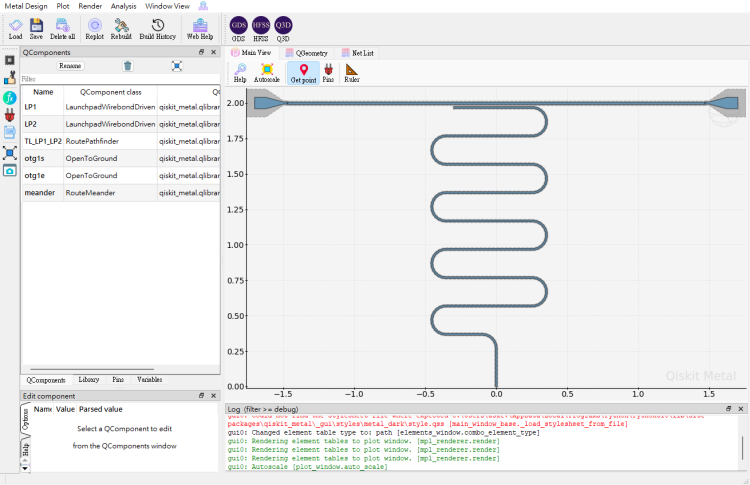

In [6]:
gui.autoscale()
gui.screenshot()

# Scattering Analysis

In [7]:
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
em1 = ScatteringImpedanceSim(design, "hfss")

In [8]:
design_name= "Sweep_DrivenModal"
qcomp_render = [] # Means to render everything in qgeometry table.
open_terminations = []

# Here, pin LP1_in and LP2_in are converted into lumped ports,
#           each with an impedance of 50 Ohms. <br>
port_list = [('LP1', 'in', 50),
             ('LP2', 'in', 50)]
box_plus_buffer = True

In [9]:
# we use HFSS as rendere
hfss = em1.renderer
hfss.start()

INFO 02:01PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:01PM [load_ansys_project]: 	Opened Ansys App
INFO 02:01PM [load_ansys_project]: 	Opened Ansys Desktop v2023.1.0
INFO 02:01PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/askev/OneDrive/文件/Ansoft/
	Project:   Project2
INFO 02:01PM [connect_design]: 	Opened active design
	Design:    HangingResonators [Solution type: HFSS Hybrid Modal Network]
WARNING 02:01PM [connect_setup]: 	No design setup detected.
ERROR 02:01PM [connect_setup]: Original error 😭: 'NoneType' object has no attribute 'name'



Exception:  Did you provide the correct setup name?                            Failed to pull up setup. 😭

In [ ]:
# Here we activate the design for a drivenmodal solution
hfss.activate_ansys_design("HangingResonator", 'drivenmodal')
setup_args = Dict(max_delta_s=0.001)
setup_args.name = 'Setup'
hfss.edit_drivenmodal_setup(setup_args)

In [10]:
# set buffer
hfss.options['x_buffer_width_mm'] = 0.1
hfss.options['y_buffer_width_mm'] = 0.1

In [11]:
# clean the design if needed
hfss.clean_active_design()

In [12]:
# render the design
hfss.render_design(selection=[], 
                   open_pins=open_terminations, 
                   port_list=port_list, 
                   box_plus_buffer = box_plus_buffer)

02:01PM 35s ERROR [render_element_path]: No modeler was found. Are you connected to an active Ansys Design?


AttributeError: 'NoneType' object has no attribute 'draw_polyline'

In [ ]:
# for acurate simulations, make sure the mesh is fine enough for the meander
hfss.modeler.mesh_length(
                'cpw_mesh',
                ['trace_meander'],
                MaxLength='0.01mm')

# Broad sweet to find the resonance

In [13]:
hfss.add_sweep(setup_name="Setup", 
               name="Sweep", 
               start_ghz=4.0,
               stop_ghz=8.0,
               count=2001,
               type="Interpolating")

In [14]:
hfss.analyze_sweep('Sweep', 'Setup')

In [15]:
hfss.plot_params(['S11', 'S21'])

UnboundLocalError: local variable 'freqs' referenced before assignment

In [ ]:
# extract the S21 parameters
freqs, Pcurves, Pparams = hfss.get_params(['S21'])

In [16]:
# find armin 
f_res = freqs[np.argmin(np.abs(Pparams.S21.values))]
f_res

NameError: name 'freqs' is not defined

# Narrow sweep around the resonance found above

In [ ]:
#fine sweep
hfss.add_sweep(setup_name="Setup", 
               name="Sweep_narrow", 
               start_ghz=np.round(f_res/1e9,3)-0.01,
               stop_ghz=np.round(f_res/1e9,3)+0.01,
               count=1001,
               type="Fast") #slow but precise

In [17]:
hfss.analyze_sweep('Sweep_narrow', 'Setup')

In [18]:
hfss.plot_params(['S11', 'S21'])

UnboundLocalError: local variable 'freqs' referenced before assignment

# Close connections

In [ ]:
em1.close()

In [19]:
hfss.disconnect_ansys()

02:01PM 39s WARNING [disconnect_ansys]: This renderer appears to be already disconnected from Ansys


In [20]:
gui.main_window.close()

True